# Data Restructuring
1. Divide each machine data (consisting of multiple sensors time series) into per day.
2. Remove unwanted sensor portion within a day
    1. for when machine is idle (ipartoptype = 0)
    2. 6-seconds of measurement cycle (ipartoptype_bit15=1), sensor data in this period is used to calculate the contamination value (they have a hand-tuned formula).
    3. use the trendline info to discriminate among days
3. Each day data will be divided at change-point (replacement), and the resulting divided data will be further divided, into n-sample segments (input).
4. Each label series within a day will be interpolated in some way. (see Label data interp strategies)
    1. Adjust label units (some are from 0 to 100, some from 0 to 1000)
    2. Remove the 2 hour delay
5. Each n-sample segment (of multiple sensors, ie 2d) will correspond to one label.
6. For each segment we will generate multiple feature vectors.






# 0. Load CSV and Labels to Process

In [ ]:
# @title 0.0 Mount Drive (data quality assumed to have been check prior)

import sys
import os
import time
from google.colab import drive
import pandas as pd

# Define paths
DRIVE_PATH = '/content/gdrive'

ADIGE_PATH = os.path.join(DRIVE_PATH, 'MyDrive/Team 1 - Adige BLM/') # !NOTE: Create a shortcut of the shared-folder in your drive
BIN_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database')
CSV_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database_CSV')
CODING_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'coding')
LABEL_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database_labels')

# Mount GDrive
try:
    # Set force_remount=True for reliability in Colab
    drive.mount(DRIVE_PATH, force_remount=True)
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    sys.exit(1)

# Wait briefly for mount
time.sleep(5)

# Check if the project directory exists
if os.path.exists(ADIGE_PATH):
    print(f"Project directory accessible at {ADIGE_PATH}\n")
else:
    print(f"Error: The project directory was not found at {ADIGE_PATH}")
    sys.exit(1)

Mounted at /content/gdrive
Project directory accessible at /content/gdrive/MyDrive/Team 1 - Adige BLM/



# 1. Import Single Machine Raw Data and Label Data

In [ ]:
# @title 1.0 Select which machine to check
#machine_name = "S0872101260506"
#machine_name = "LT7A2400640"
machine_name = "LT8A2200692"
machine_path = os.path.join(CSV_PATH, f"{machine_name}.csv")
machine_label_path = os.path.join(LABEL_PATH, f"{machine_name}.log")

In [ ]:
# @title  1.1 Load Machine CSV as DataFrame, Load labels
# Ensure CONSTANTS are defined from cell#0

import pandas as pd
import matplotlib.pyplot as plt
import os


# ------ 1. Load Inputs -------
# Print the head of each DataFrame
df = pd.read_csv(machine_path)

# Create DateTime column derived from Time(ms) column, format '%d/%m/%Y %H:%M:%S'
df['DateTime'] = pd.to_datetime(df['Time (ms)'], unit='ms')

# Extract 15th Bit of iPartOpType (1 when measurement cycle is happening)
df['iPartOpType_Bit15'] = (df['iPartOpType'].values >> 15) & 1

# ------ 1. Load Labels -------
# Read the CSV, skipping the header line.
# Note: sep=';' will incorrectly group the
# timestamp and the first data column (dT_PW) together.
temp_df = pd.read_csv(
    machine_label_path,
    skiprows=1,  # Skip the complex header
    header=None, # We'll name the columns manually
    sep=';',     # Use semicolon as the main delimiter
    engine='python' # Use python engine for flexible delimiter handling
)

# At this point, temp_df[0] looks like:
# '[09/07/2025 09:58:27 : 1752047907]    170'
# Split this into two separate columns using regex to split into 2:
    # Group 1: (.*\]) -> Captures everything from the start up to the ']'
    # \s+         -> Matches the whitespace gap
    # Group 2: (.*)   -> Captures the rest (the numeric value)
regex_pattern = r'^(.*\])\s+(.*)'
separated_col_0 = temp_df[0].str.extract(regex_pattern, expand=True) # Apply the regex to column 0, creating two new columns

# Assemble the final, clean DataFrame
label_df = pd.DataFrame()

# Add the columns from our regex split
# .str.strip('[]') removes the square brackets
label_df['Timestamp'] = separated_col_0[0].str.strip('[]')

# Add the remaining columns from the original parse
label_df['poll_PW'] = temp_df.iloc[:,-3].astype(str).str.strip()
label_df['poll_lens'] = temp_df.iloc[:,-2].astype(str).str.strip()

# Convert columns to their proper data types

# Convert numeric columns
numeric_cols = ['poll_PW', 'poll_lens']
# errors='coerce' will turn any conversion problems into 'NaN'
label_df[numeric_cols] = label_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Split the 'Timestamp' column into a readable datetime and the epoch value
ts_parts = label_df['Timestamp'].str.split(' : ', expand=True)
label_df['DateTime'] = pd.to_datetime(ts_parts[0], format='%d/%m/%Y %H:%M:%S') #dd/mm/yyyy hh:mm:ss
label_df['GMT_Epoch_ms'] = (pd.to_numeric(ts_parts[1], errors='coerce')) * 1000

# Drop the original raw 'Timestamp' column as it's now redundant
label_df = label_df.drop(columns=['Timestamp'])

# Re-order columns for a clean final DataFrame
final_columns = [
    'DateTime', 'GMT_Epoch_ms', 'poll_PW', 'poll_lens',
]
label_df = label_df[final_columns]
print(f'Loaded {machine_path}')
print(f'Loaded {machine_label_path}')

Loaded /content/gdrive/MyDrive/Team 1 - Adige BLM/database_CSV/LT8A2200692.csv
Loaded /content/gdrive/MyDrive/Team 1 - Adige BLM/database_labels/LT8A2200692.log


#2. Restructure Sensor (Input) Data and Label Data

In [ ]:
# 0. Use only Label data where there is corresponding Sensor Data
# 0. Use only certain columns of Sensor data

import pandas as pd
from datetime import timedelta

# Ensure DateTime exists in df
if 'DateTime' not in df.columns:
    df['DateTime'] = pd.to_datetime(df['Time (ms)'], unit='ms')

# --- 0.1 Select Specific Sensor Columns ---
# Define the columns we want to use as features
target_sensor_cols = [
    'DateTime', # Essential for time alignment
    '$AC_VACTW (mm/min)',
    'Gas set pressure (0.01 bar)',
    'Gas type',
    'Bar material',
    'Bar thickness',
    'Pressure (0.01 bar)',
    'Laser set power (W)',
    'Temperature lens IR (0.01 °C)',
    'Temperature window IR (0.01 °C)',
    'Temperature window BTS (0.01 °C)',
    'iPartOpType',
    'iPartOpType_Bit15'
]

# Filter df to keep only available columns from the list
available_cols = [c for c in target_sensor_cols if c in df.columns]
missing_cols = [c for c in target_sensor_cols if c not in df.columns]

if missing_cols:
    print(f"Warning: The following columns were not found and skipped: {missing_cols}")

df = df[available_cols].copy()
print(f"Filtered Sensor Data to {len(available_cols)} columns.")

# --- 1. Adjust Label Timestamps ---
# Subtract 2 hours and 6 seconds
# We use a copy to avoid side effects on re-runs
label_df_adjusted = label_df.copy()
adjustment = timedelta(hours=2, seconds=6)
label_df_adjusted['DateTime'] = label_df_adjusted['DateTime'] - adjustment

# --- 0. Filter Label Data ---
# Use only Label data where there is corresponding Sensor Data
sensor_start = df['DateTime'].min()
sensor_end = df['DateTime'].max()

label_df_filtered = label_df_adjusted[
    (label_df_adjusted['DateTime'] >= sensor_start) &
    (label_df_adjusted['DateTime'] <= sensor_end)
].copy()

# --- 1. Split into Per-Day DataFrames ---
# Sensor Data
df['Date'] = df['DateTime'].dt.date
sensor_days_list = [group for _, group in df.groupby('Date')]

# Label Data
label_df_filtered['Date'] = label_df_filtered['DateTime'].dt.date
label_days_list = [group for _, group in label_df_filtered.groupby('Date')]

# --- Print Stats ---
print(f"Time Adjustment Applied: -{adjustment}")
print(f"Sensor Data Period: {sensor_start} to {sensor_end}")
print(f"Number of Days in Sensor Data: {len(sensor_days_list)}")
print(f"Number of Days in Label Data (matched): {len(label_days_list)}")

# Optional: Print first few dates to verify
if len(sensor_days_list) > 0:
    print(f"First Sensor Date: {sensor_days_list[0]['Date'].iloc[0]}")
if len(label_days_list) > 0:
    print(f"First Label Date: {label_days_list[0]['Date'].iloc[0]}")

Filtered Sensor Data to 13 columns.
Time Adjustment Applied: -2:00:06
Sensor Data Period: 2025-07-29 06:14:59.825000 to 2025-08-29 09:08:26.757000
Number of Days in Sensor Data: 24
Number of Days in Label Data (matched): 24
First Sensor Date: 2025-07-29
First Label Date: 2025-07-29


In [ ]:
from scipy.stats import linregress
import pandas as pd
import numpy as np

valid_sensor_days = []
valid_label_days = []
dropped_days = []

basis_pollution = 'poll_PW' # day-slope of this will dictate if discard

# Configuration for slope angle filtering
MIN_VALID_SLOPE_ANGLE_DEGREES = 0   # Minimum acceptable angle in degrees (e.g., 0 for non-decreasing)
MAX_VALID_SLOPE_ANGLE_DEGREES = 0.09  # Maximum acceptable angle in degrees

# Map sensor days by date for easy retrieval
sensor_days_dict = {df['Date'].iloc[0]: df for df in sensor_days_list}

print(f"Initial days count: {len(label_days_list)}")

for label_day_df in label_days_list:
    current_date = label_day_df['Date'].iloc[0]

    # Check if corresponding sensor data exists
    if current_date not in sensor_days_dict:
        dropped_days.append((current_date, "No matching sensor data"))
        continue

    # 2.1 Measure Trendline (poll_lens vs Time)
    # We need at least 2 points to calculate a slope
    if len(label_day_df) < 2:
        dropped_days.append((current_date, f"Not enough labels (n={len(label_day_df)})"))
        # Deciding to drop if we can't verify trend, or you could keep it.
        # Assuming we want verified accumulation trends.
        continue

    # Convert DateTime to timestamp (seconds) for regression
    x = label_day_df['DateTime'].map(pd.Timestamp.timestamp).values
    y = label_day_df[basis_pollution].values

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Convert slope to angle in degrees (range -90 to 90)
    slope_angle_degrees = np.degrees(np.arctan(slope))

    # 2.2 Discard if slope angle is outside the valid range
    if MIN_VALID_SLOPE_ANGLE_DEGREES <= slope_angle_degrees <= MAX_VALID_SLOPE_ANGLE_DEGREES:
        valid_label_days.append(label_day_df)
        valid_sensor_days.append(sensor_days_dict[current_date])
    else:
        dropped_days.append((current_date, f"Invalid Slope Angle ({slope_angle_degrees:.2f} degrees)"))

# Update the main lists
label_days_list = valid_label_days
sensor_days_list = valid_sensor_days

print(f"Filtering Complete. Kept {len(valid_label_days)} days.")
print(f"Dropped {len(dropped_days)} days:")
for date_val, reason in dropped_days:
    print(f"  {date_val}: {reason}")

Initial days count: 24
Filtering Complete. Kept 13 days.
Dropped 11 days:
  2025-07-29: Invalid Slope Angle (-0.00 degrees)
  2025-07-30: Invalid Slope Angle (-0.00 degrees)
  2025-08-01: Invalid Slope Angle (-0.01 degrees)
  2025-08-06: Invalid Slope Angle (-0.00 degrees)
  2025-08-11: Invalid Slope Angle (-0.00 degrees)
  2025-08-12: Invalid Slope Angle (-0.01 degrees)
  2025-08-14: Invalid Slope Angle (-0.01 degrees)
  2025-08-20: Invalid Slope Angle (-0.00 degrees)
  2025-08-21: Invalid Slope Angle (-0.01 degrees)
  2025-08-26: Invalid Slope Angle (-0.00 degrees)
  2025-08-29: Invalid Slope Angle (-0.03 degrees)


Interpolating labels for 13 days...
Created 13 interpolated label datasets.


/tmp/ipython-input-709496495.py:117: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


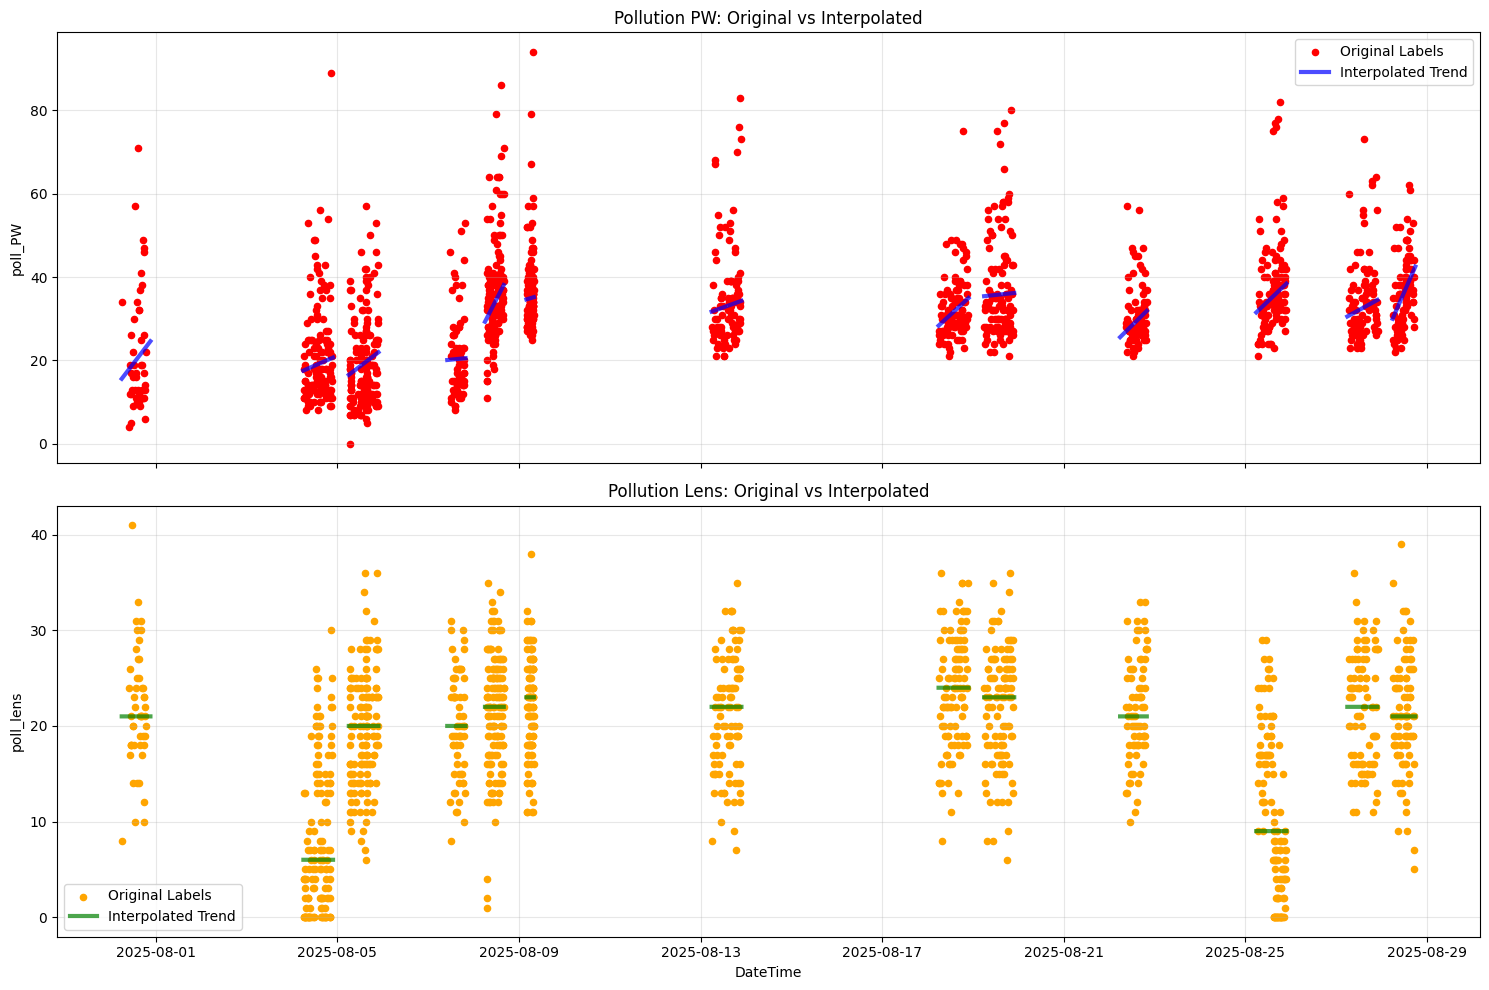

In [ ]:
from scipy.stats import linregress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interp_labels_list = []
processed_label_dfs = []

# --- Outlier Filtering Configuration ---
USE_IQR_OUTLIER_FILTERING = True  # Set to True to enable outlier filtering for poll_PW
OUTLIER_THRESHOLD_IQR_MULTIPLIER = 1.5 # Standard multiplier for IQR (e.g., 1.5 for fences)

print(f"Interpolating labels for {len(sensor_days_list)} days...")

for sensor_df, label_df in zip(sensor_days_list, label_days_list):
    # Sanity Check: Ensure dates match
    s_date = sensor_df['Date'].iloc[0]
    l_date = label_df['Date'].iloc[0]
    if s_date != l_date:
        print(f"Warning: Date mismatch {s_date} vs {l_date}")
        continue

    # --- Prepare Data ---
    # We use timestamps (seconds) for regression to handle irregular spacing correctly
    # X_sensor: The timestamps we want to predict for
    sensor_timestamps = sensor_df['DateTime'].map(pd.Timestamp.timestamp).values

    # X_label: The timestamps we have labels for
    label_timestamps = label_df['DateTime'].map(pd.Timestamp.timestamp).values
    label_pw_values = label_df['poll_PW'].values

    # --- Outlier Filtering for poll_PW (if enabled) ---
    filtered_label_df = label_df.copy() # Start with a copy
    if USE_IQR_OUTLIER_FILTERING and len(label_df) > 3: # Need enough points for IQR
        Q1 = filtered_label_df['poll_PW'].quantile(0.25)
        Q3 = filtered_label_df['poll_PW'].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - OUTLIER_THRESHOLD_IQR_MULTIPLIER * IQR
        upper_bound = Q3 + OUTLIER_THRESHOLD_IQR_MULTIPLIER * IQR

        # Filter out outliers
        filtered_label_df = filtered_label_df[
            (filtered_label_df['poll_PW'] >= lower_bound) &
            (filtered_label_df['poll_PW'] <= upper_bound)
        ]
        if len(filtered_label_df) < 2: # Ensure enough points remain for linregress
            # If too many points were filtered, fall back to original data or skip
            print(f"Warning: Outlier filtering removed too many points for {s_date}. Using original data for poll_PW.")
            filtered_label_df = label_df.copy()

    # --- Interpolate poll_PW ---
    # Fit line to sparse labels (using filtered data if applicable)
    # Ensure we have at least 2 points for linregress
    if len(filtered_label_df) >= 2:
        x_for_linregress_pw = filtered_label_df['DateTime'].map(pd.Timestamp.timestamp).values
        y_for_linregress_pw = filtered_label_df['poll_PW'].values
        slope_pw, intercept_pw, _, _, _ = linregress(x_for_linregress_pw, y_for_linregress_pw)
        # Project onto dense sensor timestamps
        interp_poll_pw = slope_pw * sensor_timestamps + intercept_pw
    else:
        # Fallback if not enough points for linregress even after filtering
        # Could use median, mean, or just previous day's slope/intercept
        print(f"Warning: Not enough data points to compute linregress for poll_PW on {s_date}. Using median.")
        interp_poll_pw = np.ones_like(sensor_timestamps) * label_df['poll_PW'].median()

    # --- Interpolate poll_lens ---
    # NOTE: just use median of label_df as the interpolated value
    interp_poll_lens = np.ones_like(interp_poll_pw)*label_df['poll_lens'].median()

    # --- Store Result ---
    day_interp_df = pd.DataFrame({
        'DateTime': sensor_df['DateTime'],
        'interp_poll_PW': interp_poll_pw,
        'interp_poll_lens': interp_poll_lens,
        'Date': s_date
    })

    # Clip negative values to 0 (Physics constraint: pollution cannot be negative)
    day_interp_df['interp_poll_PW'] = day_interp_df['interp_poll_PW'].clip(lower=0)
    day_interp_df['interp_poll_lens'] = day_interp_df['interp_poll_lens'].clip(lower=0)

    interp_labels_list.append(day_interp_df)
    processed_label_dfs.append(label_df)

print(f"Created {len(interp_labels_list)} interpolated label datasets.")

# --- Visualization ---
if len(interp_labels_list) > 0:
    all_original = pd.concat(processed_label_dfs)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Plot Scatter Points (Original Data)
    axes[0].scatter(all_original['DateTime'], all_original['poll_PW'], color='red', label='Original Labels', s=20, zorder=0)
    axes[1].scatter(all_original['DateTime'], all_original['poll_lens'], color='orange', label='Original Labels', s=20, zorder=0)

    # Plot Lines per Day (No connecting lines between days)
    for i, day_df in enumerate(interp_labels_list):
        # Only add label to the first iteration to avoid duplicate legend entries
        lbl = 'Interpolated Trend' if i == 0 else "_nolegend_"

        axes[0].plot(day_df['DateTime'], day_df['interp_poll_PW'], color='blue', alpha=0.7, linewidth=3, label=lbl)
        axes[1].plot(day_df['DateTime'], day_df['interp_poll_lens'], color='green', alpha=0.7, linewidth=3, label=lbl)

    axes[0].set_title(f'Pollution PW: Original vs Interpolated')
    axes[0].set_ylabel('poll_PW')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_title('Pollution Lens: Original vs Interpolated')
    axes[1].set_ylabel('poll_lens')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.xlabel('DateTime')
    plt.tight_layout()
    plt.show()

In [ ]:
# 4. Remove Unwanted portions of sensor data
# 5. Segment into windowed input-output

import numpy as np

# --- Configuration ---
N_WINDOW = 1024      # 51.2 seconds approx
STRIDE = 512         # 50% overlap

# Select Feature Columns
# Exclude Metadata and Control columns (iPartOpType) from the final X input
metadata_cols = ['DateTime', 'Date', 'Time (ms)']
exclude_cols = ['iPartOpType', 'iPartOpType_Bit15']

# We use the columns from the sensor dataframes
feature_cols = [c for c in sensor_days_list[0].columns
                if c not in metadata_cols and c not in exclude_cols]

print(f"\nFeature Columns ({len(feature_cols)}): {feature_cols}")

# Initialize Lists
X_list = []
y_pw_list = []
y_lens_list = []

segments_per_day = []

print(f"\nStarting Segmentation (Window={N_WINDOW}, Stride={STRIDE})...")

for i, (sensor_df, label_df) in enumerate(zip(sensor_days_list, interp_labels_list)):
    date_str = sensor_df['Date'].iloc[0]

    # 1. Define Filtering Mask
    # Keep data where:
    #   - Machine is NOT idle (iPartOpType != 0)
    #   - Machine is NOT in measurement cycle (iPartOpType_Bit15 == 0)
    # We access these columns directly from sensor_df before features are extracted
    try:
        mask = (sensor_df['iPartOpType'] != 0) & (sensor_df['iPartOpType_Bit15'] == 0)
    except KeyError as e:
        print(f"Skipping {date_str}: Missing column {e}")
        continue

    # 2. Identify Continuous Valid Blocks
    # Get indices where mask is True
    valid_indices = np.where(mask)[0]

    if len(valid_indices) == 0:
        print(f"  {date_str}: No valid data found.")
        continue

    # Split into consecutive blocks where index diff > 1
    # breaks are indices in 'valid_indices' where the jump happens
    breaks = np.where(np.diff(valid_indices) != 1)[0] + 1
    blocks = np.split(valid_indices, breaks)

    # 3. Segment Each Block
    # Convert relevant data to numpy for faster slicing
    # Note: feature_cols now excludes the OpTypes, so data_values is cleaner
    data_values = sensor_df[feature_cols].values
    label_pw_values = label_df['interp_poll_PW'].values
    label_lens_values = label_df['interp_poll_lens'].values

    day_seg_count = 0

    for block in blocks:
        # block contains indices valid for sensor_df
        block_len = len(block)

        # Skip blocks smaller than one window
        if block_len < N_WINDOW:
            continue

        # Generate Start Indices for Sliding Window
        # We slide along the block
        starts = range(0, block_len - N_WINDOW + 1, STRIDE)

        for start in starts:
            # Map block-relative indices to global dataframe indices
            # indicies of the segment in the original dataframe
            seg_indices = block[start : start + N_WINDOW]

            # Extract Input Segment (n_samples, n_features)
            x_seg = data_values[seg_indices]

            # Extract Label (Output) -> Value at the last timestamp of the segment
            last_idx = seg_indices[-1]
            y_pw = label_pw_values[last_idx]
            y_lens = label_lens_values[last_idx]

            X_list.append(x_seg)
            y_pw_list.append(y_pw)
            y_lens_list.append(y_lens)
            day_seg_count += 1

    segments_per_day.append((date_str, day_seg_count))

# 4. Aggregate Results
X_array = np.array(X_list)
y_pw_array = np.array(y_pw_list)
y_lens_array = np.array(y_lens_list)

print(f"\n--- Processing Complete ---")
print(f"Total Segments Generated: {len(X_list)}")
print(f"Input Tensor Shape (X): {X_array.shape}  (Samples, TimeSteps, Features)")
print(f"Label PW Shape (y): {y_pw_array.shape}")
print(f"Label Lens Shape (y): {y_lens_array.shape}")

# Quick stats on daily segments
print("\nSegments per day summary (First 5):")
for d, c in segments_per_day[:5]:
    print(f"  {d}: {c}")


Feature Columns (10): ['$AC_VACTW (mm/min)', 'Gas set pressure (0.01 bar)', 'Gas type', 'Bar material', 'Bar thickness', 'Pressure (0.01 bar)', 'Laser set power (W)', 'Temperature lens IR (0.01 °C)', 'Temperature window IR (0.01 °C)', 'Temperature window BTS (0.01 °C)']

Starting Segmentation (Window=1024, Stride=512)...

--- Processing Complete ---
Total Segments Generated: 12789
Input Tensor Shape (X): (12789, 1024, 10)  (Samples, TimeSteps, Features)
Label PW Shape (y): (12789,)
Label Lens Shape (y): (12789,)

Segments per day summary (First 5):
  2025-07-31: 1673
  2025-08-04: 458
  2025-08-05: 550
  2025-08-07: 536
  2025-08-08: 738


In [ ]:
# Save as pickle containing X, y_pw, y_lens, and feature names
import os
import pickle

# Define output directory
OUTPUT_DIR = os.path.join(ADIGE_PATH, 'coding', 'restructured_data_V1')

# Create directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created directory: {OUTPUT_DIR}")
else:
    print(f"Directory exists: {OUTPUT_DIR}")

# Define filename
# Using machine_name to keep it organized
output_path = os.path.join(OUTPUT_DIR, f'{machine_name}.pkl')

# Create dictionary to save
data_to_save = {
    'X': X_array,
    'y_pw': y_pw_array,
    'y_lens': y_lens_array,
    'features': feature_cols # same sequence order as columns in X
}

# Save data
print("Saving data to single pickle file...")

try:
    with open(output_path, 'wb') as f:
        pickle.dump(data_to_save, f)
    print(f"Saved all data to {output_path}")
    print("Keys available:", list(data_to_save.keys()))

except Exception as e:
    print(f"Error saving file: {e}")

Directory exists: /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/restructured_data_V1
Saving data to single pickle file...
Saved all data to /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/restructured_data_V1/LT8A2200692.pkl
Keys available: ['X', 'y_pw', 'y_lens', 'features']


In [ ]:
# Load X_array, y_pw_array, y_lens_array from the pickles
# For all feature in X and for both y, plot it in plotly as a stack of plots (add range slider)

import pickle
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Define path
pkl_path = os.path.join(ADIGE_PATH, 'restructured_data_V1', f'{machine_name}.pkl')

# 1. Load Data
print(f"Loading data from {pkl_path}...")
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

X = data['X']
y_pw = data['y_pw']
y_lens = data['y_lens']
features = data['features']

print(f"Loaded X: {X.shape}")

# 2. Prepare Data for Plotting
# X is (Samples, TimeSteps, Features).
# To visualize efficiently, we'll take the value at the LAST timestep of each segment
# This aligns with the timestamp of the label y.
X_last_step = X[:, -1, :]

# Create sample indices (0 to N-1)
x_axis = np.arange(len(y_pw))

# 3. Create Plotly Figure
# Rows = Number of features + 2 labels
num_features = len(features)
total_rows = num_features + 2

subplot_titles = features + ['Label: Poll PW', 'Label: Poll Lens']

fig = make_subplots(
    rows=total_rows,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.005,
    subplot_titles=subplot_titles
)

# Add Feature Traces
for i, feature_name in enumerate(features):
    fig.add_trace(
        go.Scatter(
            x=x_axis,
            y=X_last_step[:, i],
            name=feature_name,
            mode='markers',
            marker=dict(size=3)
        ),
        row=i+1, col=1
    )

# Add Label Traces
# Poll PW
fig.add_trace(
    go.Scatter(
        x=x_axis,
        y=y_pw,
        name='Poll PW',
        mode='markers',
        marker=dict(color='red', size=3)
    ),
    row=num_features + 1, col=1
)

# Poll Lens
fig.add_trace(
    go.Scatter(
        x=x_axis,
        y=y_lens,
        name='Poll Lens',
        mode='markers',
        marker=dict(color='orange', size=3)
    ),
    row=num_features + 2, col=1
)

# 4. Layout Settings
fig.update_layout(
    height=200 * total_rows,
    title=f"Feature Values (at segment end) vs Labels - {machine_name}",
    showlegend=False
)

# Add Range Slider to the bottom plot
fig.update_xaxes(rangeslider=dict(visible=True), row=total_rows, col=1)

fig.show()

Loading data from /content/gdrive/MyDrive/Team 1 - Adige BLM/restructured_data_V1/S0872101260506.pkl...
Loaded X: (8793, 1024, 10)


# Everything below is scratch work

In [ ]:
# 0. Use only Label data where there is corresponding Sensor Data
# 1. Subtract two hours and 6 seconds from label data timestamps (data exploration showed that label samples are delayed by 2hr6sec from when it was measured)
# 1. Split label data into per day, maybe a list of df, each df representing a day's worth of labels
# 1. Split also sensor data into per day
# 2. Remove certain days where a "lens replacement" occured
  # 2.1 Per day of label data, measure trendline. Save list of trendlines
  # 2.2 Iterating on day-labels and day-sensors, discard from list if corresponding trendline is negative
# 3. Interpolate Labels (per day). For each day-label in the list,
  # get linear regression of poll_PW for that day (use number of samples of corresponding day-sensor as new num of samples for interpd_poll_PW)
  # get linear regression of poll_lens for that day
  # create a new interpd label data, save time, interpd_poll_PW, and interpd_poll_lens for that day
# 4. Remove Unwanted portions of sensor data. For each day-sensor in the list:
  # 4.1 When ipartoptype is zero (idle machine)
  # 4.2 When ipartoptype_bit15 is 1 (measurement cycle occuring)
# 5. Segment into windowed input-output. Per day of sensor and label data
  # Starting from 0-th sample, extract as x (dim = n, #sensor) an n-sample sensor data segment (n=1024, which is 51 seconds of sensor data)
  # Take the label at timestamp equal to last timestamp of, this will be the y for this segment.
  # Save x and y as kth input and kth label
  # Move the window for dn=n/2 (ie, we get output for every 25 seconds)
  # after all that, save the structure x=(k, n, #sensor) tensor and labels as (k-dim) vector as a pickle